In [1]:
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz

--2023-12-21 12:06:34--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.207, 172.253.62.207, 142.251.163.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M   118MB/s    in 1.9s    

2023-12-21 12:06:37 (118 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [8]:
!pip install mahotas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 40.6 MB/s eta 0:00:00


In [2]:
!tar -xzvf "flower_photos.tgz" -C "." > xx
print("Unzipped")

Unzipped


In [210]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

In [5]:
import cv2
import os
import sklearn

image_size = tuple((64, 64))

def load_img(indir):
    samples = []
    labels = []
    for class_dir in os.listdir(indir):
        the_class = class_dir
        for file in os.listdir(indir+'/'+class_dir):
            image = cv2.imread("{}/{}/{}".format(indir,class_dir,file))
            #image = preprocess_input(image)
            image = cv2.resize(image, image_size)
            samples.append(image)
            labels.append(the_class)
    samples = np.array(samples)
    labels = np.array(labels)
    return samples,labels
samples, labels = load_img('flower_photos')
samples,labels = sklearn.utils.shuffle(samples,labels)
print('loaded',len(samples),' samples')
print('classes',set(labels))


loaded 3670  samples
classes {'sunflowers', 'daisy', 'roses', 'dandelion', 'tulips'}


In [6]:
org_samples, org_labels = samples, labels
samples.shape, labels.shape

((3670, 64, 64, 3), (3670,))

In [9]:
import mahotas


# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

def fd_histogram(image, mask=None):
    bins=8
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    return hist.flatten()

In [18]:
new_samples = []
for i,image in enumerate(samples):
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)
    if(i%500==0): print(i,'/',len(samples))
    features = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
    new_samples.append(features)
samples = np.array(new_samples)
#np.savetxt('samples.csv',fsamples) #save it if you want to reuse it!
print(samples.shape)

0 / 3670
500 / 3670
1000 / 3670
1500 / 3670
2000 / 3670
2500 / 3670
3000 / 3670
3500 / 3670
(3670, 532)


In [211]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
print(np.min(samples),np.max(samples))
samples = scaler.fit_transform(samples)
print(np.min(samples),np.max(samples))

0.0 1.0000000000000004
0.0 1.0


In [212]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = np.array(labels,dtype=float)
print(labels.shape)

(3670, 5)


Model Dense

In [224]:
dense_model = Sequential()
dense_model.add(Dense(256, input_dim=532, activation='relu'))
dense_model.add(Dense(128, activation='relu'))
dense_model.add(Dense(64, activation='relu'))
dense_model.add(Dense(32, activation='relu'))
dense_model.summary()
dense_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_81 (Dense)            (None, 256)               136448    
                                                                 
 dense_82 (Dense)            (None, 128)               32896     
                                                                 
 dense_83 (Dense)            (None, 64)                8256      
                                                                 
 dense_84 (Dense)            (None, 32)                2080      
                                                                 
Total params: 179680 (701.88 KB)
Trainable params: 179680 (701.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model CNN

In [225]:
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), padding="same",input_shape=(64,64,3)))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation("relu"))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(64, (3, 3), padding="same"))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation("relu"))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())
cnn_model.add(Dense(128))
cnn_model.add(Activation("relu"))
cnn_model.add(Dense(32))
cnn_model.add(Activation("relu"))

cnn_model.summary()
optimizer = tf.keras.optimizers.RMSprop(0.0001)
cnn_model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_20 (Ba  (None, 64, 64, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_39 (Activation)  (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_21 (Ba  (None, 32, 32, 64)      

Synergy Model

In [226]:
from tensorflow.keras.layers import concatenate, Dense
from tensorflow.keras.models import Model

syn_model = concatenate([dense_model.output, cnn_model.output])
syn_model = Dense(50, activation="relu")(syn_model)
syn_model = Dense(5, activation="softmax")(syn_model)

model = Model(inputs=[dense_model.input, cnn_model.input], outputs=syn_model)

model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])

Prepare dataset

In [216]:
split = 0.8
img_samples = org_samples / 255.0
trainSamples, trainLabels = [samples[0:int(len(samples)*split)], img_samples[0:int(len(img_samples)*split)]],labels[0:int(len(labels)*split)],
testSamples, testLabels = [samples[int(len(samples)*split):], img_samples[int(len(img_samples)*split):]], labels[int(len(labels)*split):],


In [227]:
H = model.fit(trainSamples, trainLabels, validation_data=(testSamples,testLabels), epochs=20, batch_size=16)

Epoch 1/20
184/184 [==============================] - 32s 156ms/step - loss: 1.4773 - accuracy: 0.4135 - val_loss: 1.5567 - val_accuracy: 0.2861
Epoch 2/20
184/184 [==============================] - 29s 156ms/step - loss: 1.0410 - accuracy: 0.5869 - val_loss: 1.2874 - val_accuracy: 0.4700
Epoch 3/20
184/184 [==============================] - 29s 157ms/step - loss: 0.8807 - accuracy: 0.6594 - val_loss: 1.0484 - val_accuracy: 0.6035
Epoch 4/20
184/184 [==============================] - 27s 149ms/step - loss: 0.7335 - accuracy: 0.7122 - val_loss: 0.9821 - val_accuracy: 0.6553
Epoch 5/20
184/184 [==============================] - 30s 163ms/step - loss: 0.6383 - accuracy: 0.7517 - val_loss: 1.2605 - val_accuracy: 0.5599
Epoch 6/20
184/184 [==============================] - 32s 172ms/step - loss: 0.5458 - accuracy: 0.7922 - val_loss: 1.1818 - val_accuracy: 0.6117
Epoch 7/20
184/184 [==============================] - 29s 156ms/step - loss: 0.4325 - accuracy: 0.8420 - val_loss: 1.0888 - val_ac

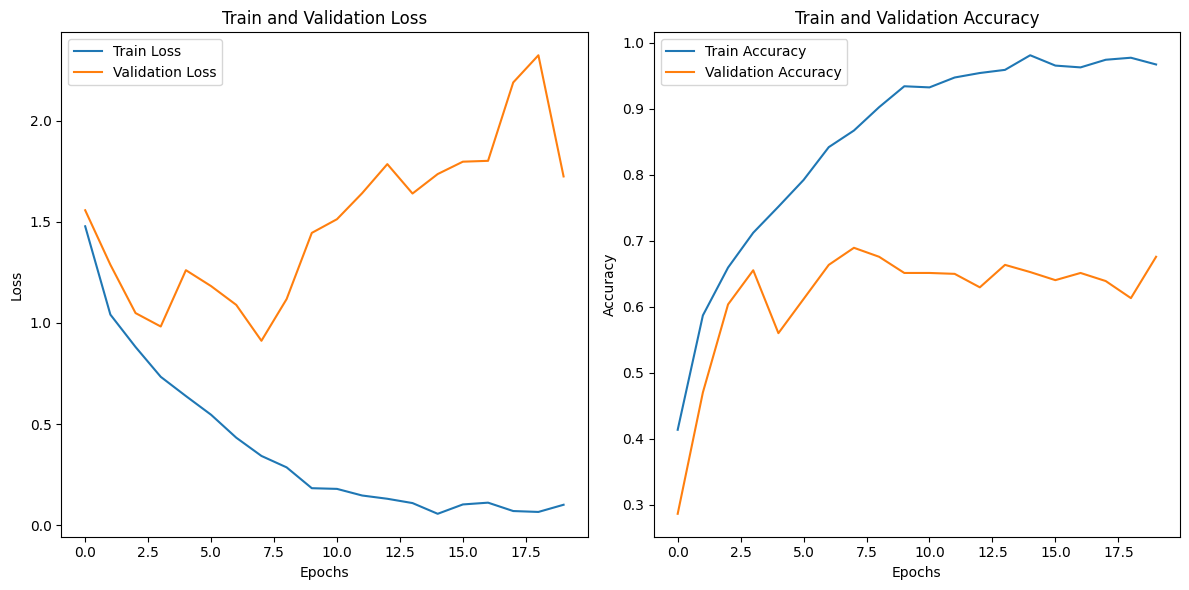

In [228]:
import matplotlib.pyplot as plt
# Wykres train_loss i val_loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(H.history['loss'], label='Train Loss')
plt.plot(H.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Wykres train_accuracy i val_accuracy
plt.subplot(1, 2, 2)
plt.plot(H.history['accuracy'], label='Train Accuracy')
plt.plot(H.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [231]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,cohen_kappa_score

modelResults = model.predict(testSamples)
print(modelResults.shape)
print(testLabels.shape)

print(confusion_matrix(testLabels.argmax(axis=1), modelResults.argmax(axis=1)))
print(classification_report(testLabels.argmax(axis=1), modelResults.argmax(axis=1)))
accuracy = accuracy_score(testLabels.argmax(axis=1), modelResults.argmax(axis=1))
print("Accuracy: {:.2f}".format(accuracy))
print("Cohen's Kappa: {:.2f}".format(cohen_kappa_score(testLabels.argmax(axis=1), modelResults.argmax(axis=1))))

23/23 [==============================] - 2s 85ms/step
(734, 5)
(734, 5)
[[ 80  20  12   2   5]
 [ 14 130  13  17   9]
 [ 13  10  69   4  32]
 [  3   7   2 121   8]
 [ 11  15  36   5  96]]
              precision    recall  f1-score   support

           0       0.66      0.67      0.67       119
           1       0.71      0.71      0.71       183
           2       0.52      0.54      0.53       128
           3       0.81      0.86      0.83       141
           4       0.64      0.59      0.61       163

    accuracy                           0.68       734
   macro avg       0.67      0.67      0.67       734
weighted avg       0.67      0.68      0.67       734

Accuracy: 0.68
Cohen's Kappa: 0.59
